In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from aurora import Aurora

import torch
from torch.utils.data import DataLoader

from bfm_finetune.aurora_mod import AuroraFlex, AuroraRaw
from bfm_finetune.plots_v2 import plot_eval
from bfm_finetune.dataloaders.geolifeclef_species.dataloader import GeoLifeCLEFSpeciesDataset
from bfm_finetune.dataloaders.dataloader_utils import custom_collate_fn
from bfm_finetune.utils import load_checkpoint, seed_everything, load_config

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

seed_everything(42)

In [2]:
base_model = Aurora(use_lora=True) # stabilise_level_agg=True
base_model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False) # strict=False
atmos_levels = (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000)
base_model.to(device)

num_species = 500

In [4]:
PATH = "/home/thanasis.trantas/github_projects/bfm-finetune/outputs/2025-04-29/16-59-52"
CHECKPOINT_PATH = Path(PATH) / "checkpoints"
cfg = load_config(PATH)

In [10]:
val_dataset = GeoLifeCLEFSpeciesDataset(num_species=num_species, mode="val", negative_lon_mode=cfg.dataset.negative_lon_mode)
val_dataloader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=custom_collate_fn,
        num_workers=1,
    )

lat_lon = val_dataset.get_lat_lon()

files 1


In [5]:
# model = AuroraFlex(base_model=base_model, in_channels=num_species, hidden_channels=160,
#                     out_channels=num_species, atmos_levels=atmos_levels, lat_lon=lat_lon,
#                     supersampling_cfg=cfg.model.supersampling)
model = AuroraRaw(base_model)
model.to(device)

params_to_optimize = model.parameters()
optimizer = torch.optim.AdamW(params_to_optimize, lr=1.0)

[LoRA]  trainable params = 192 layers
3.87 M / 1243.82 M parameters will update


In [6]:
_, _ = load_checkpoint(model, optimizer, CHECKPOINT_PATH)

Loaded checkpoint from /home/thanasis.trantas/github_projects/bfm-finetune/outputs/2025-04-29/16-59-52/checkpoints/best_checkpoint.pth (epoch 11, loss: 0.3519)


In [14]:
def plot_channel_time_slices(tensor4d, channel_idx, cmap='viridis'):
    """
    Plots each time slice of a specific channel from a 4D tensor [T, C, H, W].

    Parameters:
      tensor4d (torch.Tensor or np.ndarray): Input image with shape [T, C, H, W].
      channel_idx (int): Index of the channel to visualize.
      cmap (str): Colormap for imshow.
    """
    # Convert to numpy if tensor
    print(tensor4d.shape)
    tensor4d = tensor4d.squeeze(0)
    if torch.is_tensor(tensor4d):
        data = tensor4d.cpu().numpy()
    else:
        data = np.array(tensor4d)
        
    T, C, H, W = data.shape
    assert 0 <= channel_idx < C, f"channel_idx must be in [0, {C-1}]"
    
    # Extract the [T, H, W] array for the selected channel
    channel_data = data[:, channel_idx, :, :]

    # Create subplots
    fig, axes = plt.subplots(1, T, figsize=(6 * T, 5))
    if T == 1:
        axes = [axes]

    for t in range(T):
        im = axes[t].imshow(channel_data[t], cmap=cmap, origin='upper')
        axes[t].set_title(f'Channel {channel_idx} — Time {t}')
        axes[t].axis('off')
        fig.colorbar(im, ax=axes[t], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

torch.Size([1, 2, 500, 152, 320])


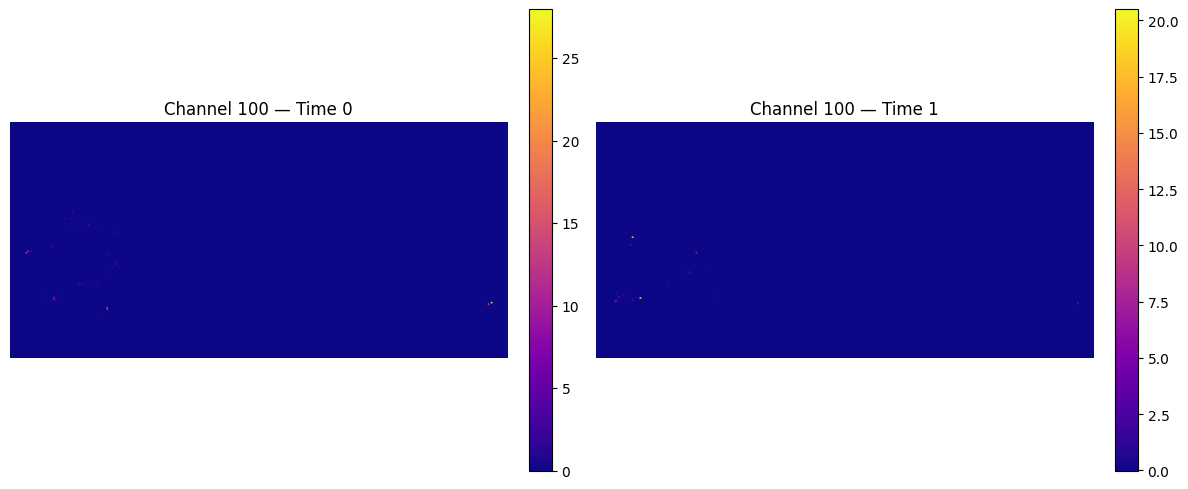

torch.Size([1, 1, 500, 152, 320])


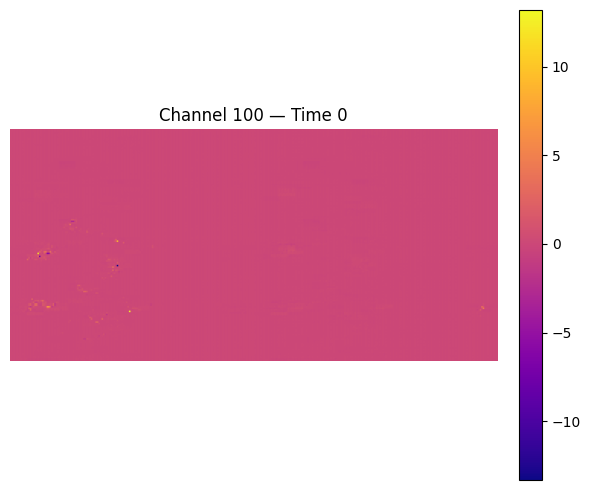

In [15]:
for sample in val_dataloader:
    batch = sample["batch"]# .to(device)
    batch["species_distribution"] = batch["species_distribution"].to(device)
    target = sample["target"]
    with torch.inference_mode():
        prediction = model.forward(batch)
        unnormalized_preds = val_dataset.scale_species_distribution(prediction.clone(), unnormalize=True)

    plot_channel_time_slices(batch["species_distribution"], channel_idx=100, cmap='plasma')
    plot_channel_time_slices(prediction, channel_idx=100, cmap='plasma')

